In [451]:
# load packages
import numpy as np 
import scipy.io
from scipy.fft import fft, ifft
from scipy.io   import  loadmat
import pandas as pd
import os
import pickle as pkl
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import time
np.random.seed(9191977) # set seed number

#### Set Main Data Dir Path ect ...

In [452]:
# Main Directory of processed file from MatLab
MainDir='D:\\AttnXV3_analysis\\RCA_F1\\RCA\\' # set dir
SaveFigDir='D:\\AttnXV3_analysis\\F1NRushPlots\\' # set dir where imgs will be saved
os.chdir(MainDir)
# Set File Name 
d=os.listdir(MainDir) # list files in dir
FileN=(d[0]) # choose one
file_path=os.path.join(MainDir, FileN) # join paths and prep 2 load
print(file_path) # does path exist ... ?
print(os.path.exists(file_path)) # yes or no
print(SaveFigDir) 
print(os.path.exists(SaveFigDir))

D:\AttnXV3_analysis\RCA_F1\RCA\rcaResults_Sweep_contrast_sweeps.mat
True
D:\AttnXV3_analysis\F1NRushPlots\
True


#### Set Some Default Params

In [453]:
NumBins=6 # number of contrasts
NumHarms=2 # number of harmonic data: 2F1, 4F1
NumComp=0 # first component from RCA
soi=21 # subjects data to look at 
NumBoots=1000 # number of shuffling arrays we will have and then plot
######################################################################
param_names=['C50','n','Rmax','b']
contrast_levels=np.array([1, 3, 5, 16, 40, 100])
contrast_levels_labs=['1%', '3%', '5%', '16%', '40%', '100%']
######################################################################
sns.set_theme()

In [454]:
c  = sns.color_palette("Paired",12) 
sns.color_palette("Paired",12)

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [483]:
d = sns.color_palette("cubehelix",12) 
sns.color_palette("cubehelix",12) 

[(0.09047371119989064, 0.05445716110232385, 0.13852748506080714),
 (0.09969720832685408, 0.15801554750586727, 0.2709350859808844),
 (0.08217360710333568, 0.2933828584411944, 0.3056769890124602),
 (0.1273556209660727, 0.40688107540873075, 0.2510509720132212),
 (0.2859128565523805, 0.4710624660630873, 0.18738893702815024),
 (0.5189779257277026, 0.4791977979866502, 0.22113568487102592),
 (0.7191546442520655, 0.47408267612900734, 0.3799983938958308),
 (0.8256488974926798, 0.5070500942798608, 0.6257479983967315),
 (0.8172332440272755, 0.6039901042725871, 0.8417612519210355),
 (0.769116287350359, 0.7357927626253576, 0.9434086075123853),
 (0.7692547706801687, 0.8676949271654195, 0.948566973832207),
 (0.8640896943830253, 0.9544571010212727, 0.9375776402960758)]

### Functions to Pass Thru Data

In [456]:
def CleanRCA(x): # replace 0's in data with nan's
    x[x == 0] = np.nan
    return x
################################################################################
# shuffle data before real and imaginary numbers are combined
def ShuffleTrials(x, NumComp):
    x = np.array(x) # set data as array
    x = x[:,NumComp,:] # get # component we want
    shuff_data = np.ones_like(x) # copy of 24 x 78
    [NumRows, NumTrials] = x.shape # 24 x 78
    TrialInd = np.array(np.arange(0,NumTrials,1)) # array = len of #Trials
    #index = np.random.shuffle(TrialInd)  # random sampling without replacement - just shuffling 
    index = np.random.randint(0,NumTrials,NumTrials) # index position (# trial) # random sampling with replacement 
    NewTrialList = TrialInd[index] # shuffled pos array
    shuff_data = x[:,NewTrialList] # set rando samp w replacment
    return shuff_data # 24 x 78 array (only want 1st rca component)
################################################################################
# comine real and imaginary numbers after shuffling, only 1st component - For average across pre and post
def CombineRealImg(x, NumHarms):
    [NumCols, NumTrials] = np.shape(x) # 24 x 78-80
    DomainCutoff = int(NumCols/NumHarms) # use to index cutoff  - float -> int
    CondCutoff = int(NumTrials/2) # 39 - 40 depends...
    pre = x[:,:CondCutoff] # 24 x 39 - 40 depends ...
    post = x[:,CondCutoff:]
    AmpPerBin = np.ones((DomainCutoff,NumHarms)) # [bins (2f1 then 4f1)] X [pre /post] \ 12 x 2
    for RowInd in range(DomainCutoff):
        ################ combining data generated from real and imaginary comp (1st half of cols and last half)
        AmpPerBin[RowInd,0] = np.hypot(np.nanmean(pre[RowInd,:]),np.nanmean(pre[RowInd+DomainCutoff,:])) # 12 x 78 PRE
        AmpPerBin[RowInd,1] = np.hypot(np.nanmean(post[RowInd,:]),np.nanmean(post[RowInd+DomainCutoff,:])) # 12 x 78 POST
    return AmpPerBin # single array output
################################################################################
# function to model curve
def naka_rushton(C, C50, n, Rmax, b):
    return ((Rmax * ((C**n) / (C50**n + C**n)))+b)

#### Load Data 1 : RCA Data for Simulations

In [457]:
mat_data = scipy.io.loadmat(file_path)
rca = mat_data['rcaResult']['projectedData'][0,0]
rcaData = [rca[i,0] for i in range(rca.shape[0])] # final data output
NumSubs = int(len(rcaData))
print(f'Total Subject Files Imported: {NumSubs}')

Total Subject Files Imported: 55


In [458]:
# load subj names
SubNames = mat_data['rcaResult'][0,0][5]
FileName = [x[0][3:] for subjlist in SubNames for x in subjlist[0][2][0]]
MySubj = FileName[soi]
print(f'Importing Data of Subj: {MySubj}')

Importing Data of Subj: 2664_attnL_20231020_1452


#### Load Data 2 : Average Contrast Response Function Pickle File

In [459]:
SaveDataDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir where avg crf were be saved
FileOps = os.listdir(SaveDataDir) # list files in dir
print(FileOps)
dataIn = FileOps[0]
print('Selected File:', dataIn)
ImportFile = os.path.join(SaveDataDir,dataIn)
print(ImportFile)
print(os.path.exists(ImportFile))
loadData = pkl.load(open(ImportFile, 'rb'))
NumSubs = int(len(loadData.keys()))
print('Average CRFs Loaded for',NumSubs,'Subjects')

['F1AverageCRF_01_31_2024.pkl']
Selected File: F1AverageCRF_01_31_2024.pkl
D:\AttnXV3_analysis\RCA_F1\AvgCRFs\F1AverageCRF_01_31_2024.pkl
True
Average CRFs Loaded for 55 Subjects


In [460]:
SubjRealData = loadData[soi] # import crf for subjects data that will iterate thru sims
RealData = np.zeros((4,6))

RealData[0,:] = SubjRealData[:6,0]
RealData[1,:] = SubjRealData[:6,1]
RealData[2,:] = SubjRealData[6:,0]
RealData[3,:] = SubjRealData[6:,1]

#### Step 1 : Remove 0's in Data and turn to NaN's

In [461]:
rca = dict()
for k in range(len(rcaData)):
    rca[k] = CleanRCA(rcaData[k])
#print(rca[0].shape) # 24 x 4 x 78

#### Step 2 : Shuffle Trials from Original Data and Save

In [462]:
shuffs = dict()
for j in range(NumBoots):
    shuffs[j] = ShuffleTrials(rca[soi], NumComp)
    #print(shuffs[j][0,0:2])
print(f'Data has been shuffled {NumBoots} times and saved ...')

Data has been shuffled 1000 times and saved ...


#### Step 3 : Combine Shuffled Data Per Frequency Per Bin on average EACH

In [463]:
psuedo_rca = dict()
for pdata in range(len(shuffs.keys())):
    psuedo_rca[pdata] = CombineRealImg(shuffs[pdata], NumHarms) # amplitude per bin per harmonic [12 x 2]
    #print(np.shape(psuedo_rca[pdata])) # shape
    #print(psuedo_rca[pdata][0:3,0]) # data generated

#### Step 4 : Split Data 12 x 2 array of data into 4 x 6 array to pass through Scipy Curve Fit

In [464]:
response_funcs = dict() # store sorted data for feed into SciPy

for j in range(NumBoots):
    temp = np.zeros((4,6)) # empty array to store sorted data in
    dataIn = psuedo_rca[j] # call data that will be sorted
    temp[0,:] = dataIn[:6,0] # pre 2f
    temp[1,:] = dataIn[:6,1] # post 2f
    temp[2,:] = dataIn[6:,0] # pre 4f
    temp[3,:] = dataIn[6:,1] # post 4f

    response_funcs[j] = temp 

#### + Quick Visual of Shuffled CRF's

Text(0.5, 0.98, 'Simulated vs Real CRFs for: 2664_attnL, Tot. Sims = 1000')

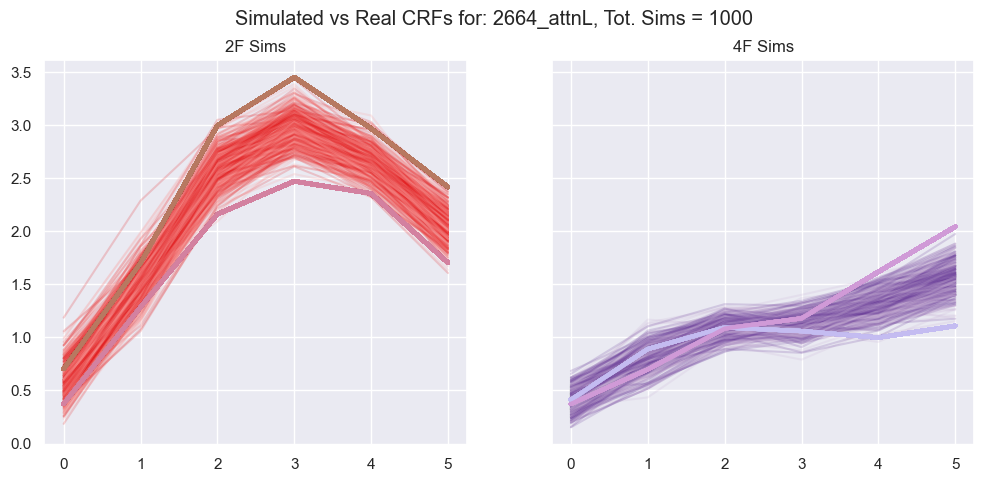

In [465]:
fig, axs = plt.subplots(1,2, figsize = (12,5), sharey = True)
for i in range(200):
    axs[0].plot(response_funcs[i][0,:], color = c[4], alpha = 1/5)
    axs[0].plot(response_funcs[i][1,:], color = c[5], alpha = 1/5)
    axs[0].plot(RealData[0,:], color = d[7], linewidth =3, label = 'pre')
    axs[0].plot(RealData[1,:], color = d[6], linewidth = 3, label = 'post')
    
    axs[0].set_title('2F Sims')

    axs[1].plot(response_funcs[i][2,:], color = c[8], alpha = 1/5)
    axs[1].plot(response_funcs[i][3,:], color = c[9], alpha = 1/5)
    axs[1].plot(RealData[2,:], color = d[9], linewidth =3, label = 'pre')
    axs[1].plot(RealData[3,:], color = d[8], linewidth = 3, label = 'post')
    axs[1].set_title('4F Sims')

plt.suptitle(f'Simulated vs Real CRFs for: {MySubj[0:10]}, Tot. Sims = {NumBoots}')

#### Step 5 : Set Params for SciPy 

In [466]:
### Model Estimates...based on nothing soild - subject to change 
c50_b = [0,300]
n_b = [0,20]
Rmax_b = [0,50]
b_b = [0,20]
boundaries=([c50_b[0],n_b[0],Rmax_b[0],b_b[0]], [c50_b[1],n_b[1],Rmax_b[1],b_b[1]]) # Boundary Params for C50, N, Rmax and B
initial_guesses = [20,1,8,0.5] # will be used to callibrate curve_fit inital params

#### Step 6 : Run SciPy Fit Curve Across All Shuffled Data and Conditions

In [467]:
# store data in dict, each row is params for a seperate condition
[NumKeys,a]=response_funcs[0].shape
NR_data = dict()

In [468]:
##### NR_data [4x4] array of NR Params computed
##### NR_data[0,:] = pre 2f
##### NR_data[1,:] = post 2f  
##### NR_data[2,:] = pre 4f 
##### NR_data[3,:] = post 4f 
for k in range(NumBoots):
    nr_params = np.zeros((NumKeys,NumKeys)) # 4x4
    for iters in range(4): 
        dataIn = response_funcs[k][iters,:] # nr for pre 2f data only
        popts = [] # clear after each iteration
        covs = [] # clear after each iteration jic
        popts, covs = curve_fit(naka_rushton,contrast_levels, dataIn, p0=initial_guesses, bounds=boundaries, nan_policy='omit', method='trf')
        nr_params[iters,:] = popts
    NR_data[k] = nr_params 

In [469]:
print(f' Performed Naka Rushton curve fit and saved params for {len(NR_data.keys())} iterations!')

 Performed Naka Rushton curve fit and saved params for 1000 iterations!


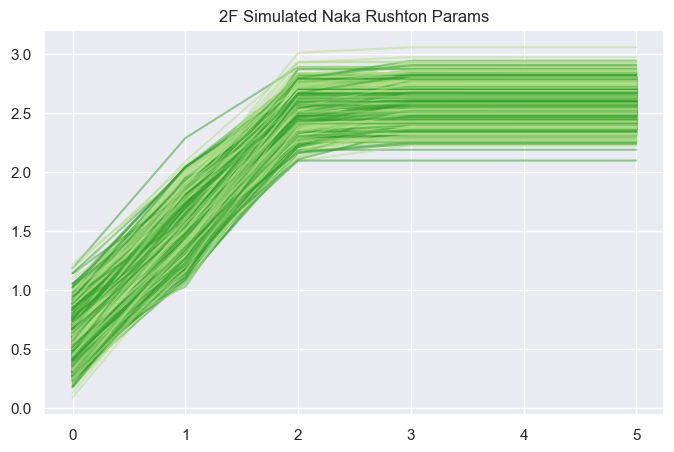

In [470]:
fig,axs = plt.subplots(figsize = (8,5), sharey = True)
for sim in range(NumBoots):

    dataIn1 = NR_data[sim][0,:]
    dataIn2 = NR_data[sim][1,:]

    axs.plot(naka_rushton(contrast_levels,dataIn1[0],dataIn1[1],dataIn1[2],dataIn1[3]), color = c[2], alpha = 1/2, label = 'pre 2f')
    axs.plot(naka_rushton(contrast_levels,dataIn2[0],dataIn2[1],dataIn2[2],dataIn2[3]), color = c[3], alpha = 1/2, label = 'post 2f')
    axs.set_title(f'2F Simulated Naka Rushton Params')


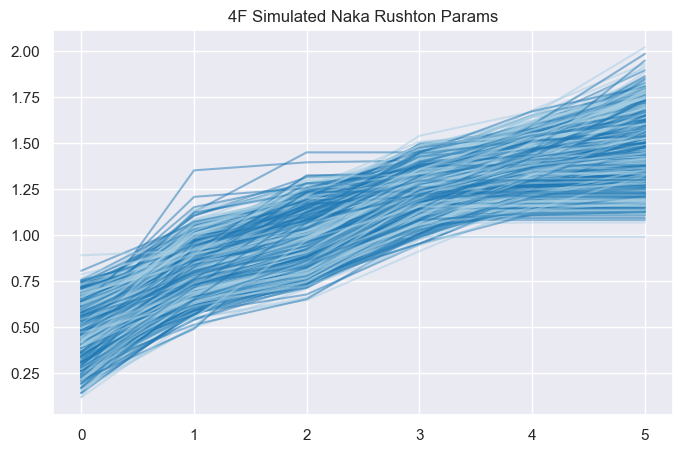

In [471]:
fig,axs = plt.subplots(figsize = (8,5), sharey = True)
for sim in range(NumBoots):
    dataIn1 = NR_data[sim][2,:]
    dataIn2 = NR_data[sim][3,:]

    axs.plot(naka_rushton(contrast_levels,dataIn1[0],dataIn1[1],dataIn1[2],dataIn1[3]), color = c[0], alpha = 1/2, label = 'pre 2f')
    axs.plot(naka_rushton(contrast_levels,dataIn2[0],dataIn2[1],dataIn2[2],dataIn2[3]), color = c[1], alpha = 1/2, label = 'post 2f')
    axs.set_title(f'4F Simulated Naka Rushton Params')

#### Calculate Percentiles for actual Parameters compared to Parameters Generated From Simulated Parameter Fits 

In [495]:
allparams = dict() # 4 keys, [1k,4] array each, num pos =  [c50,n,rmax,b]
for cnd in range(4):
    pop_params = np.zeros((NumBoots,4)) # [1k,4]
    for SimPs in range(NumBoots):
        px = NR_data[SimPs][cnd,:]
        pop_params[SimPs,:] = px
    allparams[cnd] = pop_params

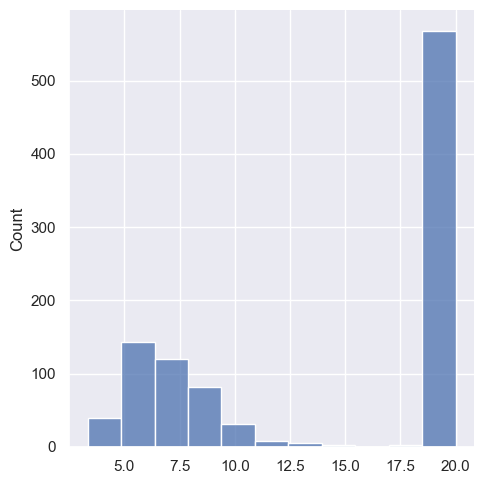

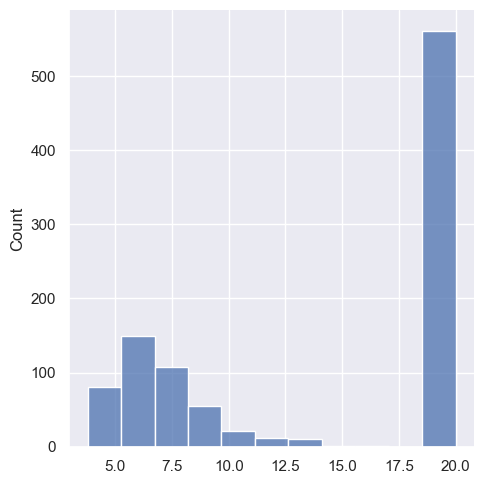

In [512]:
sns.displot(allparams[0][:,1])
sns.displot(allparams[1][:,1])

#### Step 7: Import Average CRF for Participant and Visualize on Top of Simulated Parameters Computeed

#### quantify goodness of fit for naka rushton- r^2 
### Future to do's
#### 0. do experimental analysis: 
### 1. try analysis with high contrast / saturation data find max amp and then set the proceeding values to the same amp - fix the legs for nr fit - fix saturation but not before running the analysis
### change boundaries of c50- min is 1%
### add 0% contrast response which would be the noise - number about be projected amplitude of the noise1 and noise 2 


In [ ]:
#scipy.stats.goodness_of_fit